In [1]:
#dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func, and_
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
#function to subtract one year from input date
def date_minus_one_year (input_date):
    year_earlier, month, day = input_date.split("-")
    year_earlier = str(int(year_earlier)-1)
    new_date = year_earlier+'-'+month+'-'+day
    return new_date

In [3]:
#get valid user input trip dates
valid_dates = False;
while (valid_dates == False):
    #set my trip dates and the previous year's dates
    input_start_date = input("Input trip start date in format YYYY-MM-DD: ")
    input_end_date = input("Input trip end date in format YYYY-MM-DD: ")
    #ensure end after start
    if (input_end_date < input_start_date):
        print("Invalid dates; try again")
    else:
        valid_dates = True
        #set 1 year ago dates based on input dates
        new_start_date = date_minus_one_year(input_start_date)
        new_end_date = date_minus_one_year(input_end_date)

Input trip start date in format YYYY-MM-DD: 2016-03-01
Input trip end date in format YYYY-MM-DD: 2016-03-15


In [4]:
#set up to reflect database
Base = automap_base()
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
#reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
Base.classes.keys()

['measurement', 'station']

In [7]:
Station = Base.classes.station

In [8]:
Measurement = Base.classes.measurement

In [9]:
session = Session(engine)

## Precipitation Analysis

In [10]:
#query to select the last 12 months of preciptation data; select date and prcp

#first select the latest date
result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = result[0]

#change latest_date to 1 year earlier
new_date = date_minus_one_year(latest_date)

#select date and precip for last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= new_date ).\
            order_by(Measurement.date).all()
            



In [11]:
precip_df = pd.DataFrame(results, columns=["date","prcp"]) 
#make the date the index
precip_df = precip_df.set_index("date")
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02


In [12]:
#summary statistics for preciptation over the last year
precip_df.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


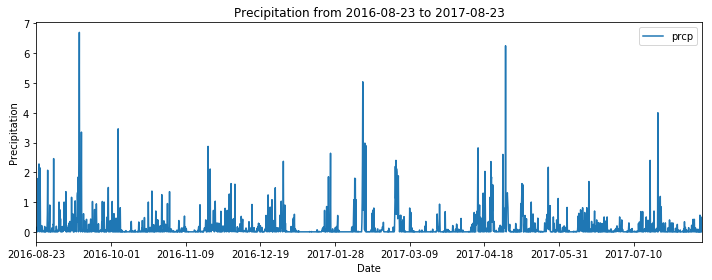

In [13]:
#plot the precipitation results using Pandas plotting

pre_plot = precip_df.iloc[::1].plot(title="Precipitation from %s to %s" % (new_date, latest_date)\
    ,figsize=(10,4))

plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.tight_layout()
plt.savefig("precip_in_hawaii.png")
plt.show()


## Station Analysis


In [14]:
#query number of stations
number_stations = session.query(Station.station_id).count()
print(number_stations)

9


In [15]:
#query most active stations
# list stations and observation counts in descending order
#join with station to get the station name


results = session.query(Measurement.station, Station.name, func.count(Measurement.measurement_id) ).\
    filter(Measurement.station == Station.station ).  \
        group_by(Measurement.station).order_by(func.count(Measurement.measurement_id).desc()).all()
 
   
results



[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [16]:
station_dict = {}
for s in results:
    station_dict[s.name] = s[2]
station_dict    

{'HONOLULU OBSERVATORY 702.2, HI US': 1979,
 'KANEOHE 838.1, HI US': 2709,
 'KUALOA RANCH HEADQUARTERS 886.9, HI US': 2202,
 'MANOA LYON ARBO 785.2, HI US': 2612,
 'PEARL CITY, HI US': 1372,
 'UPPER WAHIAWA 874.3, HI US': 511,
 'WAIHEE 837.5, HI US': 2772,
 'WAIKIKI 717.2, HI US': 2724,
 'WAIMANALO EXPERIMENTAL FARM, HI US': 2669}

In [17]:
# which station has highest number of observations?
highest_station = results[0][0]

print("The station with the highest number of observations is %s with %s observations." %\
         (results[0][1], results[0][2]) )

The station with the highest number of observations is WAIHEE 837.5, HI US with 2772 observations.


In [19]:
#query to select the last 12 months of temperature observation data (tobs) 
#  for the station with the highest number of observations

results = session.query(Measurement.date, Measurement.tobs).\
            filter(and_(Measurement.date >= new_date, Measurement.station == highest_station)).all()
                  
#results
tobs_df = pd.DataFrame(results, columns=["date","tobs"]) 
tobs_df.head()

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


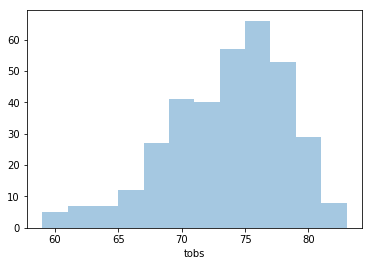

In [20]:
#plot results as histogram with bins=12
sns.distplot(tobs_df["tobs"], bins=12,norm_hist=False,kde=False)
plt.savefig("tobs_histogram_hawaii.png")
plt.show()

In [21]:
#function accepts a start date and end date in the format %Y-%m-%d and returns the minimum, 
# average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    
    
    results = session.query(Measurement.date, Measurement.tobs).\
            filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).all()
    temps_df = pd.DataFrame(results, columns=["date","tobs"]) 
    
    min_temp = temps_df["tobs"].min()
    max_temp = temps_df["tobs"].max()
    avg_temp = temps_df["tobs"].mean()
    
    
    return (min_temp, avg_temp, max_temp)

#call calc_temps for dates
trip_min_temp, trip_avg_temp, trip_max_temp = calc_temps(new_start_date, new_end_date)
print("min/avg/max: %s, %s, %s" % (trip_min_temp, trip_avg_temp, trip_max_temp))

min/avg/max: 56, 68.25714285714285, 78


## Temperature Analysis

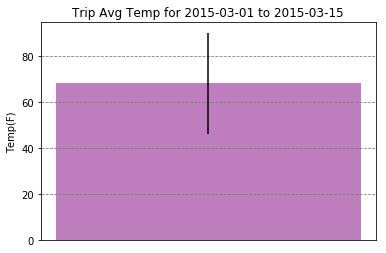

In [29]:
#plot in a bar chart
x_axis = [1]

plt.bar(x_axis, trip_avg_temp, color="purple", alpha=0.5, align="center",yerr=trip_max_temp - trip_min_temp, width=0.1)
plt.title("Trip Avg Temp for %s to %s" % (new_start_date, new_end_date))
plt.ylabel("Temp(F)")
plt.grid(axis='y',color='gray', linestyle='dashed')
plt.tick_params(axis='x', bottom='off',labelbottom='off')
plt.savefig("TripAvgTemp.png")
plt.show()

## Optional Recommended Analysis
### Rainfall per weather station for previous year's matching dates

In [23]:
#calculate rainfall for per weather station using previous year's matching dates (new_start_date, new_end_date)
results = session.query(Measurement.prcp, Measurement.station).\
            filter(and_(Measurement.date >= new_start_date, Measurement.date <= new_end_date))\
            .all()

#store in dataframe and group by station
rain_df = pd.DataFrame(results, columns=["prcp", "station"]) 

rain_by_station = rain_df.groupby(["station"])
rain_by_station["prcp"].sum()

station
USC00511918    0.19
USC00513117    1.03
USC00514830    0.71
USC00516128    3.58
USC00517948    0.00
USC00519281    2.57
USC00519397    0.65
USC00519523    0.46
Name: prcp, dtype: float64

### Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.


In [24]:
# Create a function called daily_normals that will calculate the daily normals for a specific date. 
# This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.

def daily_normals(date):
    #use just the month and day part of the date
    results = session.query(Measurement.tobs).filter(Measurement.date.like("%"+date[5:10])).all()
    temps_df = pd.DataFrame(results, columns=["tobs"])
    normal_min = temps_df["tobs"].min()
    normal_avg = temps_df["tobs"].mean()
    normal_max = temps_df["tobs"].max()
    print("daily normals: %s, %s, %s" % (normal_min, normal_avg, normal_max))
    return date, normal_min, normal_avg, normal_max

daily_normals(input_end_date)    


daily normals: 58, 68.54716981132076, 76


('2016-03-15', 58, 68.54716981132076, 76)

In [25]:
# Create a list of dates for your trip in the format %y-%m-%d. 
date_list = []
current_date = input_start_date
while(current_date <= input_end_date):
    date_list.append(current_date)
    #increment to the next date
    date1 = datetime.strptime(current_date, '%Y-%m-%d')
    date2 = date1 + timedelta(days=1)
    current_date = datetime.strftime(date2, '%Y-%m-%d')
 
print(date_list)

['2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11', '2016-03-12', '2016-03-13', '2016-03-14', '2016-03-15']


In [26]:
# Use the daily_normals function to calculate the normals for each date string and append the results to a list.
normals_list=[]
for dt in date_list:
    normals_list.append(daily_normals(dt))
    

daily normals: 64, 70.0327868852459, 76
daily normals: 61, 70.36666666666666, 78
daily normals: 60, 70.06896551724138, 78
daily normals: 57, 69.27272727272727, 77
daily normals: 60, 67.89090909090909, 76
daily normals: 60, 69.20338983050847, 76
daily normals: 60, 69.17241379310344, 78
daily normals: 59, 68.72413793103448, 78
daily normals: 57, 68.56140350877193, 75
daily normals: 57, 69.12280701754386, 75
daily normals: 60, 69.89285714285714, 82
daily normals: 62, 69.88888888888889, 80
daily normals: 56, 69.29629629629629, 77
daily normals: 62, 70.32758620689656, 77
daily normals: 58, 68.54716981132076, 76


In [27]:
# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
daily_normals_df = pd.DataFrame(normals_list, columns=["date", "tmin","tavg","tmax"])
daily_normals_df = daily_normals_df.set_index("date")
daily_normals_df.head()

,tmin,tavg,tmax
date,,,
2016-03-01,64,70.032787,76
2016-03-02,61,70.366667,78
2016-03-03,60,70.068966,78
2016-03-04,57,69.272727,77
2016-03-05,60,67.890909,76


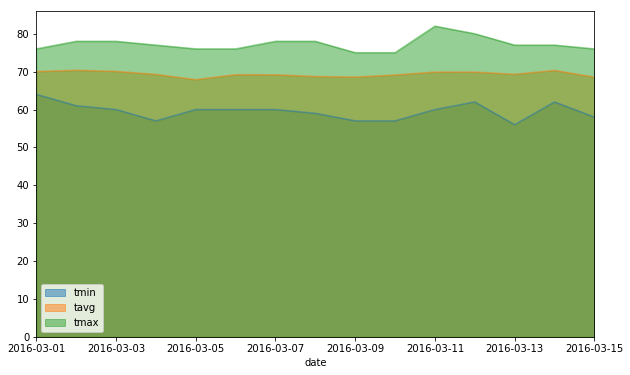

In [28]:
# Use Pandas to plot an area plot (stacked=False) for the daily normals.
daily_normals_df.plot.area(stacked=False, figsize=(10,6))
plt.savefig("daily_normals_hawaii.png")
plt.show()